In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
import scipy.ndimage as ndimage
import cv2


Open data

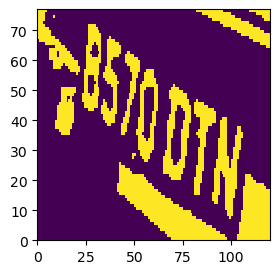

In [90]:
file = 'plates/obs3.png'
img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
np.array(img)
img = np.flipud(img)

mask = img < 145

plt.figure(figsize=(3, 3))
plt.pcolormesh(mask)

Next we can use the `clear_border` function to remove the outer border:

In [146]:
# Label the connected components
mask_labeled, num_labels = ndi.label(mask)

# Get the bounding boxes of each component
slices = ndi.find_objects(mask_labeled)

# Create a new mask without the components touching the border
new_mask = np.zeros_like(mask_labeled)
for i, slc in enumerate(slices, start=1):
    is_border = False
    for s, dim in zip(slc, mask_labeled.shape):
        if s.start == 0 or s.stop == dim:
            is_border = True
            break
    if not is_border:
        new_mask[slc] = mask_labeled[slc] * (mask_labeled[slc] == i)

# remove the rightmost object
new_mask = new_mask * (new_mask != 5)
mask = mask * (mask != 5)


# Replace the original mask with the new mask
# mask = new_mask > 0

In [121]:
len(new_mask)

77

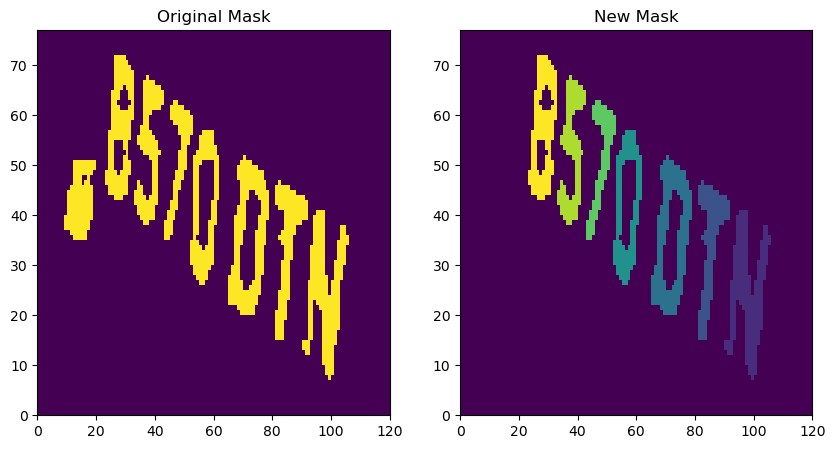

In [140]:
mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display original mask
axs[0].pcolormesh(mask)
axs[0].set_title('Original Mask')

# Display new mask
axs[1].pcolormesh(new_mask)

axs[1].set_title('New Mask')

plt.show()

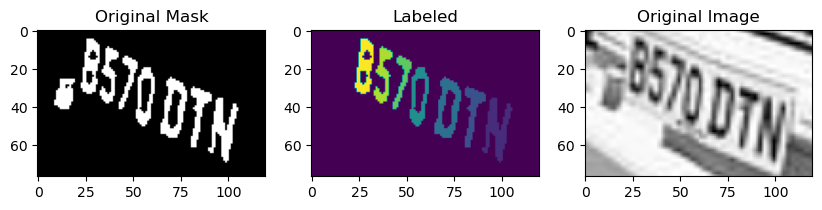

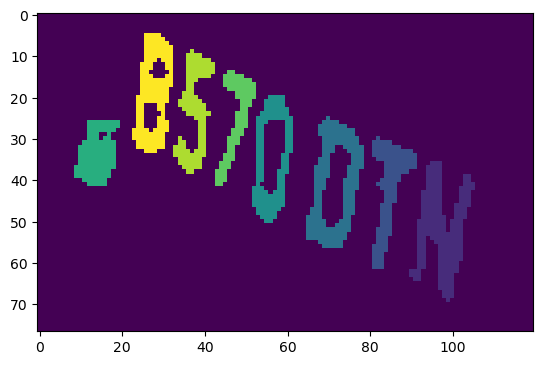

In [147]:

# Load your image
# image = cv2.imread('frame_350.jpg', cv2.IMREAD_GRAYSCALE) # frame_350.jpg
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE) # frame_350.jpg

# Preprocess the image
# Apply any necessary filtering, denoising, or smoothing operations
# For example, using a Gaussian filter:
image_filtered = ndimage.gaussian_filter(image, sigma=1)

# # Apply thresholding to create a binary mask
# mask = image_filtered > 0.1  # Replace threshold_value with an appropriate value

# # Remove small components from the mask
# mask = morphology.remove_small_objects(mask, min_size=50, connectivity=0)

# # Label the connected components
# mask_labeled = morphology.label(mask, connectivity=1)

# # Get the bounding boxes of each component
# slices = ndi.find_objects(mask_labeled)

# # Create a new mask without the components touching the border
# new_mask = np.zeros_like(mask_labeled)
# for i, slc in enumerate(slices, start=1):
#     is_border = False
#     for s, dim in zip(slc, mask_labeled.shape):
#         if s.start == 0 or s.stop == dim:
#             is_border = True
#             break
#     if not is_border:
#         new_mask[slc] = mask_labeled[slc] * (mask_labeled[slc] == i)

# # Replace the original mask with the new mask
# mask = new_mask > 0

# Display the masks
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].imshow(np.flipud(mask), cmap='gray')
axs[0].set_title('Original Mask')
axs[1].imshow(np.flipud(new_mask))
axs[1].set_title('Labeled')
axs[2].imshow(image, cmap='gray')
axs[2].set_title('Original Image')
plt.show()

slc = mask_labeled
rps = regionprops(slc)
areas = [r.area for r in rps]
np.argsort(areas)[::-1]

slc = mask_labeled
rps = regionprops(slc)
areas = [r.area for r in rps]
idxs = np.argsort(areas)[::-1] # we want largest to smallest

new_slc = np.zeros_like(slc)

new_slc = np.zeros_like(slc)
for i in idxs[:8]:
    new_slc[tuple(rps[i].coords.T)] = i+1

# plt.imshow(np.flipud(new_slc))

In [188]:
mask = mask_labeled > 0

In [189]:
mask = mask_labeled > 0
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)

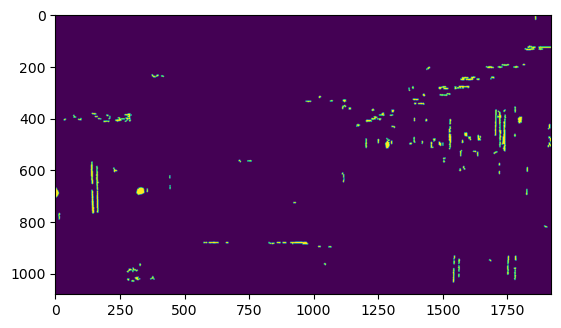

In [190]:
plt.imshow(mask)

In some slices, the trachea is kind of annoying and we need to remove it:

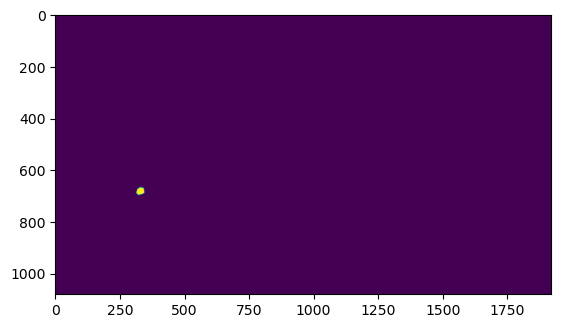

In [194]:
# Find components with area between 0.1% and 1% of the total image area
labels = label(mask, connectivity=1, background=0)
rps = regionprops(labels)
areas = np.array([r.area for r in rps])
small_components = np.where((areas / mask.size < 0.001) & (areas / mask.size > 0.0003))[0]

# Create a new mask with only the small components
small_components_mask = np.zeros_like(labels, dtype=bool)
for idx in small_components:
    small_components_mask[labels == idx + 1] = True

# # now remove all but the rightmost small component based on center of mass
# coms = np.array([r.centroid for r in rps])
# rightmost_idx = np.argmax(coms[small_components, 1])
# rightmost_component = small_components[rightmost_idx]
# small_components_mask = labels == rightmost_component + 1

# Calculate circularity only for the small components
small_eccentricities = np.array([rps[i].eccentricity for i in small_components])
small_circularity = 1 - small_eccentricities

# Find the index of the most circular component within small_components
most_circular_idx = np.argmax(small_circularity)

# Get the label of the most circular component
most_circular_component = small_components[most_circular_idx]

# Create a mask for the most circular component
small_components_mask = labels == most_circular_component + 1

plt.imshow(small_components_mask)
plt.show()

Text(0.5, 1.0, 'Original Image')

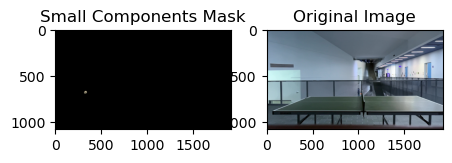

In [195]:
# now apply that mask to this image frame_350.jpg in rbg
img = cv2.imread('old_frame_170.jpg')
og_img = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img[~small_components_mask] = 0

fig, axs = plt.subplots(1,2, figsize=(5, 5))
axs[0].imshow(img)
axs[0].set_title('Small Components Mask')
axs[1].imshow(og_img)
axs[1].set_title('Original Image')


In [170]:
# get the size of the fibal small component
labels = label(small_components_mask, connectivity=1, background=0)
rps = regionprops(labels)
rps[0].area

#get that as a percent of the total frame
print(rps[0].area / mask.size)

0.0006004050925925926


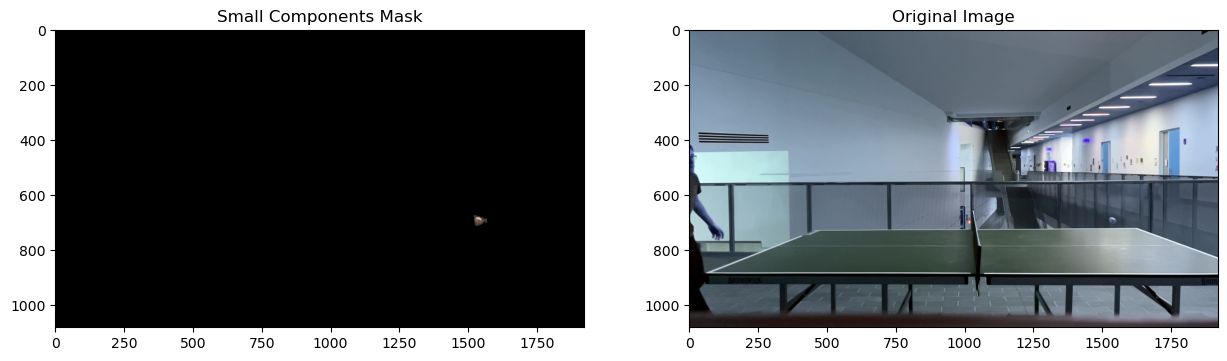

In [157]:
# now apply this mask to the old_framea-350.jpg
img = cv2.imread('old_frame_350.jpg')
og_img = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img[~small_components_mask] = 0

fig, axs = plt.subplots(1,2, figsize=(15, 15))
axs[0].imshow(img)
axs[0].set_title('Small Components Mask')
axs[1].imshow(og_img)
axs[1].set_title('Original Image')

plt.show()